In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

import inception

In [2]:
tf.__version__

'1.1.0'

In [4]:
inception.data_dir = 'C:/Users/Aman Deep Singh/Documents/Python/Data/Inception v3/inception/'
inception.maybe_download()

Data has apparently already been downloaded and unpacked.


In [5]:
model = inception.Inception()

In [7]:
resized_image = model.resized_image
y_pred = model.y_pred
y_logits = model.y_logits

In [8]:
with model.graph.as_default():
    pl_cls_target = tf.placeholder(dtype=tf.int32)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_logits, labels=[pl_cls_target])
    gradient = tf.gradients(loss, resized_image)

In [9]:
session = tf.Session(graph=model.graph)

In [10]:
def find_adversary_noise(image_path, cls_target, noise_limit=3.0, required_score=0.99, max_iterations=100):
    feed_dict = model._create_feed_dict(image_path=image_path)
    pred, image = session.run([y_pred, resized_image], feed_dict=feed_dict)
    pred = np.squeeze(pred)
    cls_source = np.argmax(pred)
    score_source_org = pred.max()
    name_source = model.name_lookup.cls_to_name(cls_source, only_first_name=True)
    name_target = model.name_lookup.cls_to_name(cls_target, only_first_name=True)
    
    noise = 0
    for i in range(max_iterations):
        print('Iteration: ', i)
        noisy_image = image + noise
        noisy_image = np.clip(a=noisy_image, a_min=0.0, a_max=255.0)
        feed_dict = {model.tensor_name_resized_image: noisy_image,
                     pl_cls_target: cls_target}
        pred, grad = session.run([y_pred, gradient], feed_dict=feed_dict)
        pred = np.squeeze(pred)
        score_source = pred[cls_source]
        score_target = pred[cls_target]
        grad = np.array(grad).squeeze()
        grad_absmax = np.abs(grad).max()
        
        if grad_absmax < 1e-10:
            grad_absmax = 1e-10
            
        step_size = 7 / grad_absmax

        # Print the score etc. for the source-class.
        msg = "Source score: {0:>7.2%}, class-number: {1:>4}, class-name: {2}"
        print(msg.format(score_source, cls_source, name_source))

        # Print the score etc. for the target-class.
        msg = "Target score: {0:>7.2%}, class-number: {1:>4}, class-name: {2}"
        print(msg.format(score_target, cls_target, name_target))

        # Print statistics for the gradient.
        msg = "Gradient min: {0:>9.6f}, max: {1:>9.6f}, stepsize: {2:>9.2f}"
        print(msg.format(grad.min(), grad.max(), step_size))

        # Newline.
        print()
        
        if score_target < required_score:
            noise -= step_size * grad
            noise = np.clip(a=noise, a_min=-noise_limit, a_max=noise_limit)
        else:
            break
            
    return image.squeeze(), noisy_image.squeeze(), noise, name_source, name_target, score_source, score_source_org, score_target

In [11]:
def normalize_image(x):
    x_min = x.min()
    x_max = x.max()
    x_norm = (x - x_min) / (x_max - x_min)
    return x_norm

In [12]:
def plot_images(image, noise, noisy_image, name_source, name_target, score_source, score_source_org, score_target):
    """
    Plot the image, the noisy image and the noise.
    Also shows the class-names and scores.

    Note that the noise is amplified to use the full range of
    colours, otherwise if the noise is very low it would be
    hard to see.

    image: Original input image.
    noise: Noise that has been added to the image.
    noisy_image: Input image + noise.
    name_source: Name of the source-class.
    name_target: Name of the target-class.
    score_source: Score for the source-class.
    score_source_org: Original score for the source-class.
    score_target: Score for the target-class.
    """
    
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 3, figsize=(10,10))

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Use interpolation to smooth pixels?
    smooth = True
    
    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    # Plot the original image.
    # Note that the pixel-values are normalized to the [0.0, 1.0]
    # range by dividing with 255.
    ax = axes.flat[0]
    ax.imshow(image / 255.0, interpolation=interpolation)
    msg = "Original Image:\n{0} ({1:.2%})"
    xlabel = msg.format(name_source, score_source_org)
    ax.set_xlabel(xlabel)

    # Plot the noisy image.
    ax = axes.flat[1]
    ax.imshow(noisy_image / 255.0, interpolation=interpolation)
    msg = "Image + Noise:\n{0} ({1:.2%})\n{2} ({3:.2%})"
    xlabel = msg.format(name_source, score_source, name_target, score_target)
    ax.set_xlabel(xlabel)

    # Plot the noise.
    # The colours are amplified otherwise they would be hard to see.
    ax = axes.flat[2]
    ax.imshow(normalize_image(noise), interpolation=interpolation)
    xlabel = "Amplified Noise"
    ax.set_xlabel(xlabel)

    # Remove ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [13]:
def adversary_example(image_path, cls_target,
                      noise_limit, required_score):
    """
    Find and plot adversarial noise for the given image.
    
    image_path: File-path to the input-image (must be *.jpg).
    cls_target: Target class-number (integer between 1-1000).
    noise_limit: Limit for pixel-values in the noise.
    required_score: Stop when target-class score reaches this.
    """

    # Find the adversarial noise.
    image, noisy_image, noise, name_source, name_target, score_source, score_source_org, score_target = find_adversary_noise(image_path=image_path,
                                                                                                                             cls_target=cls_target,
                                                                                                                             noise_limit=noise_limit,
                                                                                                                             required_score=required_score)

    # Plot the image and the noise.
    plot_images(image=image, noise=noise, noisy_image=noisy_image,
                name_source=name_source, name_target=name_target,
                score_source=score_source,
                score_source_org=score_source_org,
                score_target=score_target)

    # Print some statistics for the noise.
    msg = "Noise min: {0:.3f}, max: {1:.3f}, mean: {2:.3f}, std: {3:.3f}"
    print(msg.format(noise.min(), noise.max(),
                     noise.mean(), noise.std()))

In [14]:
image_path = 'C:/Users/Aman Deep Singh/Documents/Python/Data/Inception v3/inception/images/parrot_cropped1.jpg'

Iteration:  0
Source score:  97.52%, class-number:  409, class-name: macaw
Target score:   0.00%, class-number:  300, class-name: bookcase
Gradient min: -0.001662, max:  0.001430, stepsize:   4211.67

Iteration:  1
Source score:  86.10%, class-number:  409, class-name: macaw
Target score:   0.02%, class-number:  300, class-name: bookcase
Gradient min: -0.001767, max:  0.002306, stepsize:   3035.64

Iteration:  2
Source score:  69.52%, class-number:  409, class-name: macaw
Target score:   0.05%, class-number:  300, class-name: bookcase
Gradient min: -0.001581, max:  0.001453, stepsize:   4427.14

Iteration:  3
Source score:  26.87%, class-number:  409, class-name: macaw
Target score:   0.15%, class-number:  300, class-name: bookcase
Gradient min: -0.001345, max:  0.000986, stepsize:   5204.37

Iteration:  4
Source score:  14.77%, class-number:  409, class-name: macaw
Target score:   0.40%, class-number:  300, class-name: bookcase
Gradient min: -0.001970, max:  0.001231, stepsize:   3554

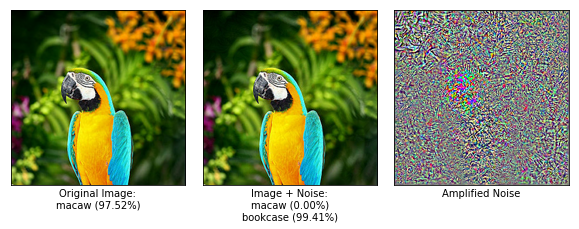

Noise min: -3.000, max: 3.000, mean: -0.001, std: 1.485


In [15]:
adversary_example(image_path=image_path,
                  cls_target=300,
                  noise_limit=3.0,
                  required_score=0.99)

Iteration:  0
Source score:  16.63%, class-number:  837, class-name: sweatshirt
Target score:   0.01%, class-number:  300, class-name: bookcase
Gradient min: -0.003983, max:  0.005454, stepsize:   1283.53

Iteration:  1
Source score:   2.21%, class-number:  837, class-name: sweatshirt
Target score:   0.31%, class-number:  300, class-name: bookcase
Gradient min: -0.005823, max:  0.006348, stepsize:   1102.73

Iteration:  2
Source score:   0.83%, class-number:  837, class-name: sweatshirt
Target score:   9.25%, class-number:  300, class-name: bookcase
Gradient min: -0.005701, max:  0.004797, stepsize:   1227.76

Iteration:  3
Source score:   0.26%, class-number:  837, class-name: sweatshirt
Target score:  68.26%, class-number:  300, class-name: bookcase
Gradient min: -0.001075, max:  0.001518, stepsize:   4611.51

Iteration:  4
Source score:   0.05%, class-number:  837, class-name: sweatshirt
Target score:  42.54%, class-number:  300, class-name: bookcase
Gradient min: -0.004384, max:  0

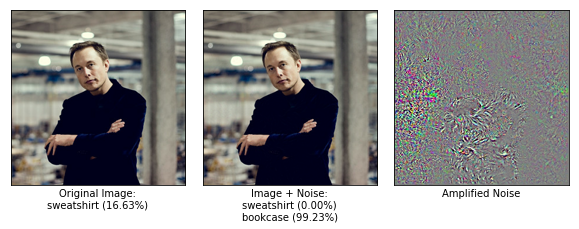

Noise min: -3.000, max: 3.000, mean: -0.000, std: 0.691


In [16]:
image_path = 'C:/Users/Aman Deep Singh/Documents/Python/Data/Inception v3/inception/images/elon_musk.jpg'
adversary_example(image_path=image_path,
                  cls_target=300,
                  noise_limit=3.0,
                  required_score=0.99)

Iteration:  0
Source score:  34.47%, class-number:  535, class-name: sunglasses
Target score:   0.03%, class-number:  300, class-name: bookcase
Gradient min: -0.002034, max:  0.002554, stepsize:   2740.46

Iteration:  1
Source score:   2.12%, class-number:  535, class-name: sunglasses
Target score:   0.13%, class-number:  300, class-name: bookcase
Gradient min: -0.000967, max:  0.000915, stepsize:   7238.92

Iteration:  2
Source score:  10.45%, class-number:  535, class-name: sunglasses
Target score:   0.33%, class-number:  300, class-name: bookcase
Gradient min: -0.001634, max:  0.001340, stepsize:   4282.74

Iteration:  3
Source score:   2.81%, class-number:  535, class-name: sunglasses
Target score:   0.75%, class-number:  300, class-name: bookcase
Gradient min: -0.001290, max:  0.001771, stepsize:   3951.69

Iteration:  4
Source score:   4.51%, class-number:  535, class-name: sunglasses
Target score:   2.00%, class-number:  300, class-name: bookcase
Gradient min: -0.001322, max:  0

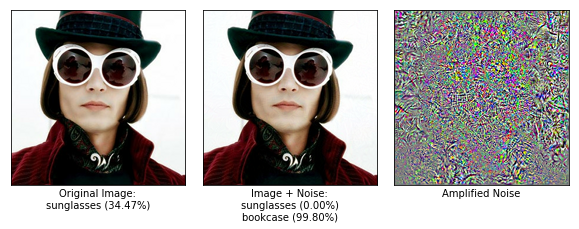

Noise min: -3.000, max: 3.000, mean: 0.009, std: 1.481


In [17]:
image_path = 'C:/Users/Aman Deep Singh/Documents/Python/Data/Inception v3/inception/images/willy_wonka_new.jpg'
adversary_example(image_path=image_path,
                  cls_target=300,
                  noise_limit=3.0,
                  required_score=0.99)

Iteration:  0
Source score:  97.98%, class-number:  817, class-name: bow tie
Target score:   0.00%, class-number:  300, class-name: bookcase
Gradient min: -0.002919, max:  0.002900, stepsize:   2398.23

Iteration:  1
Source score:  12.09%, class-number:  817, class-name: bow tie
Target score:   0.08%, class-number:  300, class-name: bookcase
Gradient min: -0.000895, max:  0.001319, stepsize:   5306.76

Iteration:  2
Source score:   1.32%, class-number:  817, class-name: bow tie
Target score:   0.29%, class-number:  300, class-name: bookcase
Gradient min: -0.000683, max:  0.000511, stepsize:  10242.67

Iteration:  3
Source score:   8.86%, class-number:  817, class-name: bow tie
Target score:   0.68%, class-number:  300, class-name: bookcase
Gradient min: -0.000778, max:  0.000730, stepsize:   9002.81

Iteration:  4
Source score:   1.05%, class-number:  817, class-name: bow tie
Target score:   1.21%, class-number:  300, class-name: bookcase
Gradient min: -0.000602, max:  0.000627, stepsi

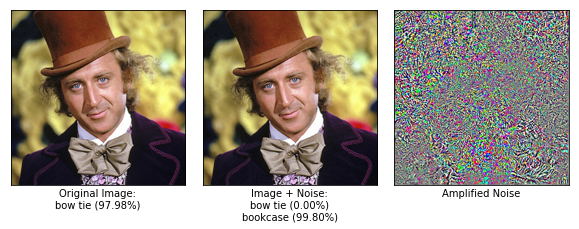

Noise min: -3.000, max: 3.000, mean: -0.001, std: 1.424


In [18]:
image_path = 'C:/Users/Aman Deep Singh/Documents/Python/Data/Inception v3/inception/images/willy_wonka_old.jpg'
adversary_example(image_path=image_path,
                  cls_target=300,
                  noise_limit=3.0,
                  required_score=0.99)

In [19]:
session.close()
model.close()